In [1]:
# Install the Hugging Face 'datasets' library to easily load the dataset
# !pip install -U datasets

# U-Net Autoencoder with a Pretrained ShuffleNetV2 Encoder

This notebook demonstrates how to build and train a U-Net-like autoencoder for image reconstruction. The key idea is to leverage a powerful, pretrained model, **ShuffleNetV2**, as the encoder (the contracting path of the U-Net). We will then build a custom decoder (the expanding path) and train it to reconstruct images from the Tiny-ImageNet dataset.

### Key Concepts:
1.  **Transfer Learning:** We use a ShuffleNetV2 model pretrained on ImageNet. This provides a robust feature extractor without needing to train it from scratch.
2.  **U-Net Architecture:** We adopt the U-Net structure, which includes an encoder, a decoder, and **skip connections**. Skip connections help the decoder recover fine-grained details by feeding it high-resolution features from the encoder.
3.  **Two-Phase Training:**
    *   **Phase 1:** Freeze the pretrained encoder and train only the newly initialized decoder. This allows the decoder to learn how to use the encoder's features effectively without corrupting the pretrained weights with large, random gradients.
    *   **Phase 2:** Unfreeze the entire model and fine-tune it end-to-end with a very low learning rate. This allows the encoder to slightly adapt its features for the specific task of reconstruction.

![U-Net Architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)
**<center>General U-Net Architecture. Our model follows this pattern.</center>**

## 1. Setup and Imports

First, we import all the necessary libraries. We'll use `torch` and `torchvision` for model building and training, `datasets` for data loading, and `matplotlib` for visualization.

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from piqa import SSIM

import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

## 2. Data Loading and Preprocessing

### 2.1. Loading the Tiny-ImageNet Dataset

We use the `datasets` library from Hugging Face to load the `tiny-imagenet` dataset. This is a smaller version of the famous ImageNet dataset, containing 200 classes with 500 training images, 50 validation images, and 50 test images per class. The images are 64x64 pixels.

We'll specify a `cache_dir` to store the downloaded data.

Training set shape: (100000, 2)
Validation set shape: (10000, 2)

Sample image:


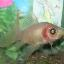

In [2]:
# Load the training and validation splits from the Hugging Face Hub
train_dataset = load_dataset('Maysee/tiny-imagenet', split='train', cache_dir='./tiny-imagenet-cache')
val_dataset = load_dataset('Maysee/tiny-imagenet', split='valid', cache_dir='./tiny-imagenet-cache')

# Print the shape of the datasets
print("Training set shape:", train_dataset.shape)
print("Validation set shape:", val_dataset.shape)

# Display a sample image to see what the data looks like
print("\nSample image:")
train_dataset[0]['image']

### 2.2. Device Configuration and Image Transformations

We'll set up the device to use a GPU (`cuda`) if available, which will significantly speed up training.

Next, we define the image transformations. All images must be the same size to be processed in batches, and they need to be converted to PyTorch tensors.
- `transforms.Resize((64, 64))`: Ensures all images are 64x64 pixels.
- `transforms.ToTensor()`: Converts the PIL Image to a PyTorch tensor and normalizes pixel values from the `[0, 255]` range to the `[0.0, 1.0]` range.

We apply these transforms on-the-fly using the `set_transform` method of the `datasets` object.

In [3]:
# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the image transformations
image_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

def apply_transforms(batch):
    """Applies the transformations to a batch of images."""
    # The .convert('RGB') is important to handle potential grayscale images
    batch['image'] = [image_transforms(img.convert('RGB')) for img in batch['image']]
    return batch

# Apply the transformation to both datasets
train_dataset.set_transform(apply_transforms)
val_dataset.set_transform(apply_transforms)

Using device: cuda


### 2.3. Creating DataLoaders

The `DataLoader` is a PyTorch utility that provides an iterable over the dataset. It handles batching, shuffling, and parallel data loading. We create one for the training set and one for the validation set.

In [4]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=torch.utils.data.default_collate # Standard collate function to batch tensors
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False, # No need to shuffle validation data
    collate_fn=torch.utils.data.default_collate
)

## 3. Model Architecture

We will now define our U-Net-like autoencoder. It consists of three main components:
1.  **Encoder**: The contracting path, built from the initial layers of a pretrained ShuffleNetV2.
2.  **Decoder Block**: A reusable block for the expanding path.
3.  **AutoEncoder**: The full model that connects the encoder, a central bottleneck, and the decoder with skip connections.

### 3.1. The Encoder

The encoder's job is to downsample the input image and extract increasingly complex features. We create a custom `Encoder` class that wraps the initial layers of `ShuffleNet_V2_X1_0`. During the forward pass, it saves the output of several layers to be used as skip connections for the decoder.

In [5]:
class Encoder(nn.Module):
    """
    The encoder part of the U-Net, built from a pretrained ShuffleNetV2.
    It captures features at multiple scales for the skip connections.
    """
    def __init__(self, original_model):
        super().__init__()
        # We take layers directly from the pretrained ShuffleNetV2
        self.conv1 = original_model.conv1
        self.maxpool = original_model.maxpool
        self.stage2 = original_model.stage2
        self.stage3 = original_model.stage3
        self.stage4 = original_model.stage4
        self.conv5 = original_model.conv5

    def forward(self, x):
        # Input: [N, 3, 64, 64]
        s0 = x
        x = self.conv1(x)    # -> [N, 24, 32, 32]
        s1 = x
        x = self.maxpool(x)  # -> [N, 24, 16, 16]
        s2 = x
        x = self.stage2(x)   # -> [N, 116, 8, 8]
        s3 = x
        x = self.stage3(x)   # -> [N, 232, 4, 4]
        s4 = x
        x = self.stage4(x)   # -> [N, 464, 2, 2] (Note: ShuffleNetV2 x1.0 has 464 out channels here)

        # The bottleneck is the final feature map before the fully connected layers
        bottleneck = self.conv5(x) # -> [N, 1024, 2, 2]

        # Return the bottleneck and the skip connections in order from deep to shallow
        return bottleneck, [s4, s3, s2, s1]

### 3.2. The Decoder Block

The decoder upsamples the feature maps and reconstructs the image. We define a `DecoderBlock` that will be used repeatedly. Each block takes an upsampled feature map, concatenates it with a skip connection from the encoder, and applies two convolutional layers. This is a standard pattern in U-Net architectures.

In [6]:
class DecoderBlock(nn.Module):
    """
    A single block in the decoder path. It concatenates the upsampled features
    with the corresponding skip connection and applies two convolutions.
    """
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        # The first convolution takes the concatenated feature maps
        self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x, skip_connection):
        # Concatenate along the channel dimension
        x = torch.cat([x, skip_connection], dim=1)
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        return x

### 3.3. Assembling the Full Autoencoder

Now, we combine the `Encoder` and `DecoderBlock`s to create the final `AutoEncoder` model.

The forward pass logic is as follows:
1.  The input image goes through the `Encoder`.
2.  The resulting `bottleneck` is processed by a "center" convolution.
3.  The decoder path begins. In each step, we:
    a. Upsample the feature map (`F.interpolate`).
    b. Pass it through a `DecoderBlock` along with the corresponding `skip_connection`.
4.  A final convolution maps the features to the desired number of output channels (3 for an RGB image).
5.  A `sigmoid` activation is applied to ensure the output pixel values are in the `[0, 1]` range, matching the input normalization.

In [16]:
class Decoder(nn.Module):
    """
    The decoder part of the U-Net. It takes the bottleneck and skip connections
    from the Encoder and upsamples them to reconstruct the original image.
    """
    def __init__(self, n_classes=3):
        super().__init__()
        # Center (Bottleneck processing)
        self.center_conv = nn.Conv2d(1024, 512, kernel_size=1)

        # Decoder blocks
        # Skip connection channels (from deep to shallow): 232, 116, 24, 24
        self.dec_block1 = DecoderBlock(512, 232, 256)
        self.dec_block2 = DecoderBlock(256, 116, 128)
        self.dec_block3 = DecoderBlock(128, 24, 64)
        self.dec_block4 = DecoderBlock(64, 24, 32)

        # Final output layer
        self.final_conv = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, bottleneck, skips):
        """
        Args:
            bottleneck (torch.Tensor): The feature map from the deepest part of the encoder.
            skips (list of torch.Tensor): A list of feature maps from the encoder's
                                          skip connections, ordered from deep to shallow.
        """
        # Center
        d = self.center_conv(bottleneck) # -> [N, 512, 2, 2]

        # Decoder path with skip connections
        d = F.interpolate(d, scale_factor=2, mode='bilinear', align_corners=True) # 2x2 -> 4x4
        d = self.dec_block1(d, skips[0]) # Use first skip connection

        d = F.interpolate(d, scale_factor=2, mode='bilinear', align_corners=True) # 4x4 -> 8x8
        d = self.dec_block2(d, skips[1]) # Use second skip connection

        d = F.interpolate(d, scale_factor=2, mode='bilinear', align_corners=True) # 8x8 -> 16x16
        d = self.dec_block3(d, skips[2]) # Use third skip connection

        d = F.interpolate(d, scale_factor=2, mode='bilinear', align_corners=True) # 16x16 -> 32x32
        d = self.dec_block4(d, skips[3]) # Use fourth skip connection

        # Final upsampling and convolution
        d = F.interpolate(d, scale_factor=2, mode='bilinear', align_corners=True) # 32x32 -> 64x64
        output = self.final_conv(d)

        return torch.sigmoid(output)
    
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        bottleneck, skips = self.encoder(x)
        reconstruction = self.decoder(bottleneck, skips)
        return reconstruction

In [17]:
weights = torchvision.models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1
shufflenet_original = torchvision.models.shufflenet_v2_x1_0(weights=weights)

encoder = Encoder(shufflenet_original)
decoder = Decoder(n_classes=3)

# Instantiate the model and move it to the configured device
model = AutoEncoder(encoder, decoder).to(device)

# Print the model architecture
print(model)

AutoEncoder(
  (encoder): Encoder(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (stage2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
        )
        (branch2): Sequential(
          (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d

## 4. Training the Model

We'll use Mean Squared Error (MSE) as the loss function, which measures the average squared difference between the original and reconstructed images.

As mentioned, we use a two-phase training strategy for better and more stable results.

### 4.1. Phase 1: Training the Decoder Only

In this phase, we **freeze the encoder's weights**. This means only the decoder and center convolution parameters will be updated. We use a relatively high learning rate since the decoder is being trained from scratch.

In [18]:
# Loss function
criterion = nn.MSELoss()

print("--- PHASE 1: Training the Decoder Only ---")
num_epochs_phase1 = 5

# Step 1: Freeze the encoder's weights
for param in model.encoder.parameters():
    param.requires_grad = False

# Step 2: Create an optimizer that only updates the trainable parameters (decoder and center)
# This is more efficient than passing all parameters.
optimizer_phase1 = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

for epoch in range(num_epochs_phase1):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        inputs = batch['image'].to(device)

        # Forward pass
        reconstructions = model(inputs)
        loss = criterion(reconstructions, inputs)

        # Backward pass and optimization
        optimizer_phase1.zero_grad()
        loss.backward()
        optimizer_phase1.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            print(f"Phase 1 - Epoch [{epoch+1}/{num_epochs_phase1}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader)
    print(f"--- End of Phase 1 Epoch {epoch+1}, Average Loss: {epoch_loss:.4f} ---")

--- PHASE 1: Training the Decoder Only ---
Phase 1 - Epoch [1/5], Step [100/3125], Loss: 0.0100
Phase 1 - Epoch [1/5], Step [200/3125], Loss: 0.0080
Phase 1 - Epoch [1/5], Step [300/3125], Loss: 0.0100
Phase 1 - Epoch [1/5], Step [400/3125], Loss: 0.0073
Phase 1 - Epoch [1/5], Step [500/3125], Loss: 0.0062
Phase 1 - Epoch [1/5], Step [600/3125], Loss: 0.0065
Phase 1 - Epoch [1/5], Step [700/3125], Loss: 0.0069
Phase 1 - Epoch [1/5], Step [800/3125], Loss: 0.0089
Phase 1 - Epoch [1/5], Step [900/3125], Loss: 0.0071
Phase 1 - Epoch [1/5], Step [1000/3125], Loss: 0.0094
Phase 1 - Epoch [1/5], Step [1100/3125], Loss: 0.0067
Phase 1 - Epoch [1/5], Step [1200/3125], Loss: 0.0063
Phase 1 - Epoch [1/5], Step [1300/3125], Loss: 0.0080
Phase 1 - Epoch [1/5], Step [1400/3125], Loss: 0.0082
Phase 1 - Epoch [1/5], Step [1500/3125], Loss: 0.0062
Phase 1 - Epoch [1/5], Step [1600/3125], Loss: 0.0087
Phase 1 - Epoch [1/5], Step [1700/3125], Loss: 0.0059
Phase 1 - Epoch [1/5], Step [1800/3125], Loss: 0

### 4.2. Phase 2: Fine-Tuning the Entire Model

Now that the decoder has learned the basics, we **unfreeze the encoder**. We will now train the entire network end-to-end. It is crucial to use a **very low learning rate** in this phase to avoid destroying the valuable pretrained weights of the encoder. We are only "fine-tuning" them for our specific reconstruction task.

In [19]:
criterion_l1 = nn.L1Loss()
criterion_ssim = SSIM(n_channels=3, reduction='mean').to(device)

print("\n--- PHASE 2: Unfreezing the Encoder and Fine-Tuning ---")
num_epochs_phase2 = 5
alpha = 0.85

# Step 3: Unfreeze the encoder's weights
for param in model.encoder.parameters():
    param.requires_grad = True

# Step 4: Create a new optimizer for the entire model with a low learning rate
optimizer_phase2 = optim.Adam(model.parameters(), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer_phase2, mode='min', factor=0.1, patience=2, verbose=True)

for epoch in range(num_epochs_phase2):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        inputs = batch['image'].to(device)

        # Forward pass
        reconstructions = model(inputs)
        loss_l1 = criterion_l1(reconstructions, inputs)
        loss_ssim_val = 1 - criterion_ssim(reconstructions, inputs)

        loss = alpha * loss_l1 + (1 - alpha) * loss_ssim_val

        # Backward pass and optimization
        optimizer_phase2.zero_grad()
        loss.backward()
        optimizer_phase2.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            print(f"Phase 2 - Epoch [{epoch+1}/{num_epochs_phase2}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader)
    scheduler.step(epoch_loss)
    print(f"--- End of Phase 2 Epoch {epoch+1}, Average Loss: {epoch_loss:.4f} ---")

print("\nTraining completed.")


--- PHASE 2: Unfreezing the Encoder and Fine-Tuning ---
Phase 2 - Epoch [1/5], Step [100/3125], Loss: 0.0799
Phase 2 - Epoch [1/5], Step [200/3125], Loss: 0.0816
Phase 2 - Epoch [1/5], Step [300/3125], Loss: 0.0807
Phase 2 - Epoch [1/5], Step [400/3125], Loss: 0.0714
Phase 2 - Epoch [1/5], Step [500/3125], Loss: 0.0765
Phase 2 - Epoch [1/5], Step [600/3125], Loss: 0.0851
Phase 2 - Epoch [1/5], Step [700/3125], Loss: 0.0841
Phase 2 - Epoch [1/5], Step [800/3125], Loss: 0.0843
Phase 2 - Epoch [1/5], Step [900/3125], Loss: 0.0844
Phase 2 - Epoch [1/5], Step [1000/3125], Loss: 0.0851
Phase 2 - Epoch [1/5], Step [1100/3125], Loss: 0.0827
Phase 2 - Epoch [1/5], Step [1200/3125], Loss: 0.0833
Phase 2 - Epoch [1/5], Step [1300/3125], Loss: 0.0783
Phase 2 - Epoch [1/5], Step [1400/3125], Loss: 0.0754
Phase 2 - Epoch [1/5], Step [1500/3125], Loss: 0.0751
Phase 2 - Epoch [1/5], Step [1600/3125], Loss: 0.0717
Phase 2 - Epoch [1/5], Step [1700/3125], Loss: 0.0689
Phase 2 - Epoch [1/5], Step [1800/

## 5. Evaluation and Visualization

Finally, let's visually inspect the quality of our autoencoder's reconstructions. We will take a batch of images from the validation set, pass them through the trained model, and plot the original images alongside their reconstructed versions.

Shape of latent bottleneck: torch.Size([32, 1024, 2, 2])
Number of skip connections: 4
Shapes of skip connections: [torch.Size([32, 232, 4, 4]), torch.Size([32, 116, 8, 8]), torch.Size([32, 24, 16, 16]), torch.Size([32, 24, 32, 32])]


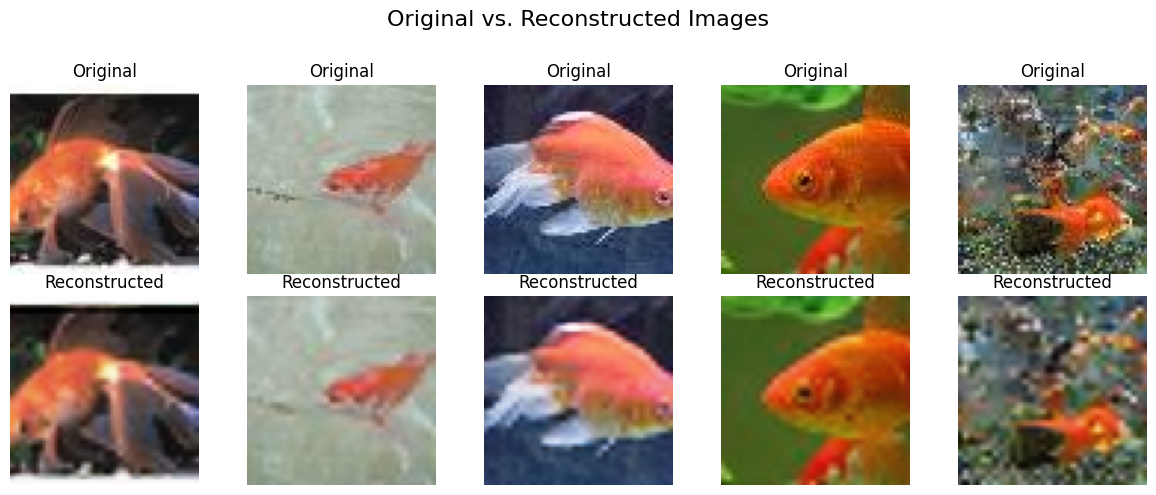

In [22]:
# Set the model to evaluation mode
model.eval()

# Use torch.no_grad() to disable gradient calculations for inference
with torch.no_grad():
    # Get a batch of validation data
    val_batch = next(iter(val_loader))
    sample_inputs = val_batch['image'].to(device)

    # Get the model's reconstructions
    latent_bottleneck, latent_skips = model.encoder(sample_inputs)

    print(f"Shape of latent bottleneck: {latent_bottleneck.shape}")
    print(f"Number of skip connections: {len(latent_skips)}")
    print(f"Shapes of skip connections: {[skip.shape for skip in latent_skips]}")

    reconstructed_images = model.decoder(latent_bottleneck, latent_skips)

# Move tensors to the CPU and convert to NumPy arrays for plotting
sample_inputs_cpu = sample_inputs.cpu().numpy()
reconstructed_images_cpu = reconstructed_images.cpu().numpy()

# --- Visualization ---
n_images_to_show = 5
plt.figure(figsize=(12, 5))
plt.suptitle("Original vs. Reconstructed Images", fontsize=16)

for i in range(n_images_to_show):
    # Display Original Image
    ax = plt.subplot(2, n_images_to_show, i + 1)
    # Transpose from (C, H, W) to (H, W, C) for matplotlib
    plt.imshow(np.transpose(sample_inputs_cpu[i], (1, 2, 0)))
    ax.set_title("Original")
    ax.axis("off")

    # Display Reconstructed Image
    ax = plt.subplot(2, n_images_to_show, i + 1 + n_images_to_show)
    plt.imshow(np.transpose(reconstructed_images_cpu[i], (1, 2, 0)))
    ax.set_title("Reconstructed")
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [21]:
# Saving the model:
model_path = "autoencoder_shufflenet.pth"

model_states = {
    'encoder_state_dict': model.encoder.state_dict(),
    'decoder_state_dict': model.decoder.state_dict(),
}

# Save the dictionary to a file
torch.save(model_states, model_path)